In [78]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
import optuna
from optuna.trial import TrialState

In [79]:
#Data was visualised in 'CreditCardFraudPrediction_DataVisualization_and_FeatureSelection' notebook
#Selecting all positives and some 15000 negatives(shuffled)
#Number of required false negatives can be tuned as well.

ccdb = pd.read_csv('creditcarddb/creditcard.csv')
db1 = ccdb.loc[(np.abs(ccdb.iloc[:,12].mean() - ccdb.iloc[:,12]))/ccdb.iloc[:,12].std() > 3]
db2 = ccdb.loc[((np.abs(ccdb.iloc[:,12].mean() - ccdb.iloc[:,12]))/ccdb.iloc[:,12].std() < 3) & (ccdb['Class'] == 1) ]
db3 = ccdb.loc[((np.abs(ccdb.iloc[:,12].mean() - ccdb.iloc[:,12]))/ccdb.iloc[:,12].std() < 3) & (ccdb['Class'] == 0)]
db3 = db3.sample(frac = 1)
db3 =  db3.iloc[:15000,:]
ccdb = pd.concat([db1, db2, db3], ignore_index=True)
ccdb = ccdb.sample(frac = 1)
print("Percentage of True positives in the dataset: "'{s}'" % ".format(s = round((ccdb['Class'].sum()/ccdb['Class'].count()) * 100,2)))
ccdb.shape

Percentage of True positives in the dataset: 2.66 % 


(18516, 31)

In [80]:
#Due to skewness of data, f1 score will be a better measure than accuracy

def custom_f1(y_true, y_pred):
    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [81]:
#This code is valid only if we use random state. train and test data must come from the same distribution.
def split_scale_data(df_x,df_y,test_size=0.2,phase='train'):
    
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size = 0.2, random_state= 5) 
    Scalar = StandardScaler()
    Scalar.fit(x_train)
    x_train = Scalar.transform(x_train)
    x_test = Scalar.transform(x_test)
    
    if phase == 'train':
        x = x_train
        y = y_train
        
    elif phase == 'test':
        x = x_test
        y = y_test
        
    return x,y

In [73]:
#Optuna will try to tune this using different values for H params
def define_model(trial):
    
    n_layers = trial.suggest_int("n_layers",1,3)
    layers = []
    activation_list=["relu","sigmoid"]
    
    model = tf.keras.Sequential()
    for i in range(n_layers):
        
        #We'll automate hyperparm tuning using a bayesien method
        num_nodes = int(trial.suggest_loguniform('n_units_{}'.format(i),4,128))
        activation = trial.suggest_categorical("activation_{}".format(i),activation_list)
        dropout_rate = trial.suggest_float('dropout_rate_{}'.format(i),0.0,0.95)
        lambda_reg = trial.suggest_float('lambda_reg_{}'.format(i),1e-10, 1e-3, log=True)
        
        #basic NN model 
        model.add(tf.keras.layers.Dense(num_nodes,input_shape = (30,),activation=activation,kernel_regularizer=tf.keras.regularizers.l2(lambda_reg)))
        model.add(tf.keras.layers.Dropout(dropout_rate))
        model.add(tf.keras.layers.BatchNormalization())
    
    #adding the output layer
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

    return model
        

In [74]:
#We try to find the best Optimizer as well

def create_optimizer(trial):
    # We optimize the choice of optimizers as well as their parameters.
    kwargs = {}
    optimizer_options = ["RMSprop", "Adam", "SGD"]
    optimizer_selected = trial.suggest_categorical("optimizer", optimizer_options)
    if optimizer_selected == "RMSprop":
        kwargs["learning_rate"] = trial.suggest_float("rmsprop_learning_rate", 1e-5, 1e-1, log=True)
        kwargs["decay"] = trial.suggest_float("rmsprop_decay", 0.85, 0.99)
        kwargs["momentum"] = trial.suggest_float("rmsprop_momentum", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "Adam":
        kwargs["learning_rate"] = trial.suggest_float("adam_learning_rate", 1e-5, 1e-1, log=True)
    elif optimizer_selected == "SGD":
        kwargs["learning_rate"] = trial.suggest_float("sgd_opt_learning_rate", 1e-5, 1e-1, log=True)
        kwargs["momentum"] = trial.suggest_float("sgd_opt_momentum", 1e-5, 1e-1, log=True)

    optimizer = getattr(tf.optimizers, optimizer_selected)(**kwargs)
    return optimizer

In [75]:
EPOCHS = 725

#Will explore Pruning more in the next project
PRUNING_INTERVAL_STEPS = 50

In [76]:
#I used a custom metric to be as the objective, my goal was to tune Hparams to fix bias and variance at the same time

def objective(trial):
    
    x_train,y_train = split_scale_data(ccdb.iloc[:,:-1],ccdb.iloc[:,-1])
    
#     learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2, log = True)
    
    batch_size = trial.suggest_int("batch_size",100,10000)
    optimizer = create_optimizer(trial)
    bce = tf.keras.losses.BinaryCrossentropy()
    
    # Build model and compile.
    model = define_model(trial)
    model.compile(optimizer=optimizer,loss=bce,metrics=custom_f1)
    history = model.fit(x_train,y_train,batch_size=batch_size,validation_split=0.2,epochs=EPOCHS)
    
    f1 = history.history['val_custom_f1'][-1]
    loss = history.history['loss'][-1]
    val_loss =  history.history['val_loss'][-1]

    optuna_pruning_hook = optuna.integration.TensorFlowPruningHook(
        trial=trial,
        estimator=model,
        metric=(abs(loss - val_loss)*40) - f1,
        run_every_steps=PRUNING_INTERVAL_STEPS,
    )
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    #clearing the model after every test
    del model
    K.clear_session()
    
    # :)
    return (abs(loss - val_loss)*40) - f1

In [82]:
#This works amazingly well!
''''[I 2021-10-10 23:09:40,228] Trial 84 finished with value: -0.855547696352005 and parameters: 
{'learning_rate': 0.0021393523564096763, 'batch_size': 5326, 'optimizer': 'Adam', 'adam_learning_rate': 0.056347979238179594,
'n_layers': 2, 'n_units_0': 32.792881084659115, 'activation_0': 'relu', 'dropout_rate_0': 0.7268295637416722,
'lambda_reg_0': 5.8003894835056825e-06, 'n_units_1': 35.78671685284347, 'activation_1': 'sigmoid',
'dropout_rate_1': 0.2226073287239269, 'lambda_reg_1': 1.018643186769918e-09}. 
Best is trial 84 with value: -0.855547696352005.'''

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=200)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2021-10-11 02:18:03,350] A new study created in memory with name: no-name-cf630f3e-ba27-474b-ab90-91879a7818f7


Epoch 1/725
2/2 [==============================] - 1s 177ms/step - loss: 0.9269 - custom_f1: 0.0460 - val_loss: 0.5950 - val_custom_f1: 0.0182
Epoch 2/725
2/2 [==============================] - 0s 24ms/step - loss: 0.8813 - custom_f1: 0.0456 - val_loss: 0.5616 - val_custom_f1: 0.0118
Epoch 3/725
2/2 [==============================] - 0s 22ms/step - loss: 0.8360 - custom_f1: 0.0474 - val_loss: 0.5312 - val_custom_f1: 0.0000e+00
Epoch 4/725
2/2 [==============================] - 0s 23ms/step - loss: 0.7946 - custom_f1: 0.0442 - val_loss: 0.5035 - val_custom_f1: 0.0000e+00
Epoch 5/725
2/2 [==============================] - 0s 22ms/step - loss: 0.7582 - custom_f1: 0.0464 - val_loss: 0.4780 - val_custom_f1: 0.0000e+00
Epoch 6/725
2/2 [==============================] - 0s 22ms/step - loss: 0.7211 - custom_f1: 0.0498 - val_loss: 0.4551 - val_custom_f1: 0.0000e+00
Epoch 7/725
2/2 [==============================] - 0s 22ms/step - loss: 0.6937 - custom_f1: 0.0439 - val_loss: 0.4347 - val_custom_

Epoch 57/725
2/2 [==============================] - 0s 22ms/step - loss: 0.2325 - custom_f1: 0.0864 - val_loss: 0.1586 - val_custom_f1: 0.0000e+00
Epoch 58/725
2/2 [==============================] - 0s 22ms/step - loss: 0.2311 - custom_f1: 0.1280 - val_loss: 0.1573 - val_custom_f1: 0.0000e+00
Epoch 59/725
2/2 [==============================] - 0s 22ms/step - loss: 0.2269 - custom_f1: 0.1003 - val_loss: 0.1561 - val_custom_f1: 0.0000e+00
Epoch 60/725
2/2 [==============================] - 0s 21ms/step - loss: 0.2261 - custom_f1: 0.0929 - val_loss: 0.1549 - val_custom_f1: 0.0000e+00
Epoch 61/725
2/2 [==============================] - 0s 22ms/step - loss: 0.2275 - custom_f1: 0.0667 - val_loss: 0.1538 - val_custom_f1: 0.0000e+00
Epoch 62/725
2/2 [==============================] - 0s 21ms/step - loss: 0.2231 - custom_f1: 0.0972 - val_loss: 0.1527 - val_custom_f1: 0.0000e+00
Epoch 63/725


KeyboardInterrupt: 

In [ ]:
#I used a custom metric to be as the objective, my goal was to tune Hparams to fix bias and variance at the same time

def objective(trial):
    
    x_train,y_train = split_scale_data(ccdb.iloc[:,:-1],ccdb.iloc[:,-1])
    
#     learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-2, log = True)
    
    batch_size = trial.suggest_int("batch_size",100,10000)
    optimizer = create_optimizer(trial)
    bce = tf.keras.losses.BinaryCrossentropy()
    
    # Build model and compile.
    model = define_model(trial)
    model.compile(optimizer=optimizer,loss=bce,metrics=custom_f1)
    history = model.fit(x_train,y_train,batch_size=batch_size,validation_split=0.2,epochs=EPOCHS)
    
    f1 = history.history['val_custom_f1'][-1]
    loss = history.history['loss'][-1]
    val_loss =  history.history['val_loss'][-1]

    optuna_pruning_hook = optuna.integration.TensorFlowPruningHook(
        trial=trial,
        estimator=model,
        metric=(abs(loss - val_loss)*40) - f1,
        run_every_steps=PRUNING_INTERVAL_STEPS,
    )
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    #clearing the model after every test
    del model
    K.clear_session()
    
    # :)
    return (abs(loss - val_loss)*40) - f1

In [85]:
#A better way would be to just load the best model instead of manually creating another model

def final_model(input_shape,lr):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32,input_shape = (input_shape,),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(5.8e-06)))
    model.add(tf.keras.layers.Dropout(0.72))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(36,activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(1.09e-09)))
    model.add(tf.keras.layers.Dropout(0.22))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    bce = tf.keras.losses.BinaryCrossentropy()
    model.compile(optimizer=optimizer,loss=bce,metrics=custom_f1)
    
    return model
    

In [86]:
#The reason I love this tuner is because it gets of overfitting 'val loss almost equal to loss'
#F1 score is not the best, but this was expected, the source data is already PCA transformed and tough to work with
#We can further improve this by using feature selection, and changing the amount of data that we trained this model on
#F1 score of over 90 should be achievable without overfitting

model = final_model(30, 0.0563)
x_train,y_train = split_scale_data(ccdb.iloc[:,:-1],ccdb.iloc[:,-1])
history = model.fit(x_train,y_train,batch_size=5326,validation_split=0.2,epochs=EPOCHS)

Epoch 1/725
3/3 [==============================] - 1s 97ms/step - loss: 0.7648 - custom_f1: 0.0810 - val_loss: 0.4073 - val_custom_f1: 0.2316
Epoch 2/725
3/3 [==============================] - 0s 16ms/step - loss: 0.3331 - custom_f1: 0.2852 - val_loss: 0.1086 - val_custom_f1: 0.0000e+00
Epoch 3/725
3/3 [==============================] - 0s 16ms/step - loss: 0.1156 - custom_f1: 0.6093 - val_loss: 0.0729 - val_custom_f1: 0.0000e+00
Epoch 4/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0602 - custom_f1: 0.6698 - val_loss: 0.1204 - val_custom_f1: 0.0000e+00
Epoch 5/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0637 - custom_f1: 0.6539 - val_loss: 0.1593 - val_custom_f1: 0.0000e+00
Epoch 6/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0678 - custom_f1: 0.6638 - val_loss: 0.1806 - val_custom_f1: 0.0000e+00
Epoch 7/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0644 - custom_f1: 0.7372 - val_loss: 0.1905 - val_cust

Epoch 57/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0390 - custom_f1: 0.8008 - val_loss: 0.0691 - val_custom_f1: 0.0000e+00
Epoch 58/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0379 - custom_f1: 0.8058 - val_loss: 0.0667 - val_custom_f1: 0.0000e+00
Epoch 59/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0353 - custom_f1: 0.8163 - val_loss: 0.0705 - val_custom_f1: 0.0000e+00
Epoch 60/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0361 - custom_f1: 0.7876 - val_loss: 0.0747 - val_custom_f1: 0.0000e+00
Epoch 61/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0374 - custom_f1: 0.8006 - val_loss: 0.0690 - val_custom_f1: 0.0000e+00
Epoch 62/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0368 - custom_f1: 0.8279 - val_loss: 0.0632 - val_custom_f1: 0.0000e+00
Epoch 63/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0374 - custom_f1: 0.7977 - val_loss: 0.0622

3/3 [==============================] - 0s 15ms/step - loss: 0.0369 - custom_f1: 0.8188 - val_loss: 0.0383 - val_custom_f1: 0.8158
Epoch 114/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0352 - custom_f1: 0.8025 - val_loss: 0.0357 - val_custom_f1: 0.8182
Epoch 115/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0359 - custom_f1: 0.8068 - val_loss: 0.0380 - val_custom_f1: 0.8105
Epoch 116/725
3/3 [==============================] - 0s 14ms/step - loss: 0.0353 - custom_f1: 0.7791 - val_loss: 0.0410 - val_custom_f1: 0.8158
Epoch 117/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0357 - custom_f1: 0.8088 - val_loss: 0.0384 - val_custom_f1: 0.8158
Epoch 118/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0380 - custom_f1: 0.8154 - val_loss: 0.0362 - val_custom_f1: 0.8182
Epoch 119/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0363 - custom_f1: 0.7993 - val_loss: 0.0370 - val_custom_f1: 0.8182
Epoch 

Epoch 170/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0357 - custom_f1: 0.8428 - val_loss: 0.0351 - val_custom_f1: 0.8158
Epoch 171/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0355 - custom_f1: 0.8174 - val_loss: 0.0348 - val_custom_f1: 0.8235
Epoch 172/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0358 - custom_f1: 0.7817 - val_loss: 0.0333 - val_custom_f1: 0.8235
Epoch 173/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0341 - custom_f1: 0.8205 - val_loss: 0.0331 - val_custom_f1: 0.8625
Epoch 174/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0368 - custom_f1: 0.7981 - val_loss: 0.0337 - val_custom_f1: 0.8258
Epoch 175/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0348 - custom_f1: 0.8038 - val_loss: 0.0348 - val_custom_f1: 0.8235
Epoch 176/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0356 - custom_f1: 0.8201 - val_loss: 0.0345 - val_custom_f1:

Epoch 227/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0353 - custom_f1: 0.7939 - val_loss: 0.0332 - val_custom_f1: 0.8312
Epoch 228/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0343 - custom_f1: 0.8084 - val_loss: 0.0332 - val_custom_f1: 0.8553
Epoch 229/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0347 - custom_f1: 0.8374 - val_loss: 0.0333 - val_custom_f1: 0.8625
Epoch 230/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0341 - custom_f1: 0.8149 - val_loss: 0.0333 - val_custom_f1: 0.8625
Epoch 231/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0356 - custom_f1: 0.8264 - val_loss: 0.0340 - val_custom_f1: 0.8553
Epoch 232/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0325 - custom_f1: 0.8394 - val_loss: 0.0353 - val_custom_f1: 0.8312
Epoch 233/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0363 - custom_f1: 0.8035 - val_loss: 0.0330 - val_custom_f1:

Epoch 284/725
3/3 [==============================] - 0s 17ms/step - loss: 0.0361 - custom_f1: 0.8077 - val_loss: 0.0358 - val_custom_f1: 0.8182
Epoch 285/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0350 - custom_f1: 0.7808 - val_loss: 0.0358 - val_custom_f1: 0.8235
Epoch 286/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0345 - custom_f1: 0.8232 - val_loss: 0.0347 - val_custom_f1: 0.8312
Epoch 287/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0344 - custom_f1: 0.8209 - val_loss: 0.0356 - val_custom_f1: 0.8462
Epoch 288/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0346 - custom_f1: 0.8444 - val_loss: 0.0381 - val_custom_f1: 0.8235
Epoch 289/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0351 - custom_f1: 0.8308 - val_loss: 0.0354 - val_custom_f1: 0.8235
Epoch 290/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0347 - custom_f1: 0.8199 - val_loss: 0.0348 - val_custom_f1:

Epoch 341/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0342 - custom_f1: 0.8418 - val_loss: 0.0350 - val_custom_f1: 0.8589
Epoch 342/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0336 - custom_f1: 0.8425 - val_loss: 0.0349 - val_custom_f1: 0.8642
Epoch 343/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0335 - custom_f1: 0.8066 - val_loss: 0.0341 - val_custom_f1: 0.8642
Epoch 344/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0343 - custom_f1: 0.8100 - val_loss: 0.0341 - val_custom_f1: 0.8625
Epoch 345/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0354 - custom_f1: 0.7971 - val_loss: 0.0361 - val_custom_f1: 0.8408
Epoch 346/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0353 - custom_f1: 0.8190 - val_loss: 0.0352 - val_custom_f1: 0.8553
Epoch 347/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0348 - custom_f1: 0.8040 - val_loss: 0.0351 - val_custom_f1:

Epoch 398/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0352 - custom_f1: 0.8251 - val_loss: 0.0345 - val_custom_f1: 0.8625
Epoch 399/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0336 - custom_f1: 0.8302 - val_loss: 0.0346 - val_custom_f1: 0.8625
Epoch 400/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0329 - custom_f1: 0.8338 - val_loss: 0.0361 - val_custom_f1: 0.8625
Epoch 401/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0343 - custom_f1: 0.8281 - val_loss: 0.0348 - val_custom_f1: 0.8625
Epoch 402/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0362 - custom_f1: 0.8030 - val_loss: 0.0350 - val_custom_f1: 0.8625
Epoch 403/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0348 - custom_f1: 0.8310 - val_loss: 0.0350 - val_custom_f1: 0.8625
Epoch 404/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0353 - custom_f1: 0.8185 - val_loss: 0.0342 - val_custom_f1:

Epoch 455/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0365 - custom_f1: 0.8288 - val_loss: 0.0351 - val_custom_f1: 0.8625
Epoch 456/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0370 - custom_f1: 0.8451 - val_loss: 0.0344 - val_custom_f1: 0.8481
Epoch 457/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0352 - custom_f1: 0.7878 - val_loss: 0.0351 - val_custom_f1: 0.8258
Epoch 458/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0363 - custom_f1: 0.7894 - val_loss: 0.0347 - val_custom_f1: 0.8333
Epoch 459/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0359 - custom_f1: 0.8077 - val_loss: 0.0346 - val_custom_f1: 0.8481
Epoch 460/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0372 - custom_f1: 0.8215 - val_loss: 0.0350 - val_custom_f1: 0.8481
Epoch 461/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0371 - custom_f1: 0.8628 - val_loss: 0.0357 - val_custom_f1:

Epoch 512/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0362 - custom_f1: 0.8250 - val_loss: 0.0330 - val_custom_f1: 0.8696
Epoch 513/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0361 - custom_f1: 0.8246 - val_loss: 0.0338 - val_custom_f1: 0.8696
Epoch 514/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0366 - custom_f1: 0.7981 - val_loss: 0.0343 - val_custom_f1: 0.8553
Epoch 515/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0353 - custom_f1: 0.8194 - val_loss: 0.0357 - val_custom_f1: 0.8553
Epoch 516/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0373 - custom_f1: 0.8149 - val_loss: 0.0349 - val_custom_f1: 0.8553
Epoch 517/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0369 - custom_f1: 0.8195 - val_loss: 0.0346 - val_custom_f1: 0.8696
Epoch 518/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0366 - custom_f1: 0.7797 - val_loss: 0.0343 - val_custom_f1:

Epoch 569/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0368 - custom_f1: 0.8320 - val_loss: 0.0352 - val_custom_f1: 0.8642
Epoch 570/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0396 - custom_f1: 0.8285 - val_loss: 0.0355 - val_custom_f1: 0.8696
Epoch 571/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0382 - custom_f1: 0.8378 - val_loss: 0.0332 - val_custom_f1: 0.8696
Epoch 572/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0366 - custom_f1: 0.8027 - val_loss: 0.0323 - val_custom_f1: 0.8696
Epoch 573/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0363 - custom_f1: 0.8198 - val_loss: 0.0325 - val_custom_f1: 0.8696
Epoch 574/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0358 - custom_f1: 0.8236 - val_loss: 0.0334 - val_custom_f1: 0.8625
Epoch 575/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0360 - custom_f1: 0.8146 - val_loss: 0.0344 - val_custom_f1:

Epoch 626/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0366 - custom_f1: 0.8144 - val_loss: 0.0343 - val_custom_f1: 0.8481
Epoch 627/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0381 - custom_f1: 0.8100 - val_loss: 0.0348 - val_custom_f1: 0.8481
Epoch 628/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0366 - custom_f1: 0.8172 - val_loss: 0.0371 - val_custom_f1: 0.8333
Epoch 629/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0380 - custom_f1: 0.8291 - val_loss: 0.0361 - val_custom_f1: 0.8258
Epoch 630/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0359 - custom_f1: 0.8444 - val_loss: 0.0363 - val_custom_f1: 0.8258
Epoch 631/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0370 - custom_f1: 0.8298 - val_loss: 0.0379 - val_custom_f1: 0.8182
Epoch 632/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0361 - custom_f1: 0.8273 - val_loss: 0.0370 - val_custom_f1:

Epoch 683/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0362 - custom_f1: 0.8112 - val_loss: 0.0353 - val_custom_f1: 0.8481
Epoch 684/725
3/3 [==============================] - 0s 15ms/step - loss: 0.0352 - custom_f1: 0.8273 - val_loss: 0.0363 - val_custom_f1: 0.8481
Epoch 685/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0357 - custom_f1: 0.8314 - val_loss: 0.0358 - val_custom_f1: 0.8553
Epoch 686/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0362 - custom_f1: 0.8212 - val_loss: 0.0350 - val_custom_f1: 0.8765
Epoch 687/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0380 - custom_f1: 0.7884 - val_loss: 0.0358 - val_custom_f1: 0.8481
Epoch 688/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0360 - custom_f1: 0.8342 - val_loss: 0.0387 - val_custom_f1: 0.8462
Epoch 689/725
3/3 [==============================] - 0s 16ms/step - loss: 0.0359 - custom_f1: 0.8432 - val_loss: 0.0373 - val_custom_f1:

In [87]:
#Evaluate loss and F1 on test data
x_test,y_test = split_scale_data(ccdb.iloc[:,:-1],ccdb.iloc[:,-1], phase='test')
model.test_on_batch(x_test, y_test)

[0.03555995225906372, 0.868494987487793]

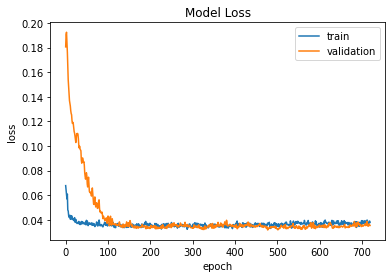

In [89]:
#Visualize loss on train and validation datasets

plt.plot(history.history['loss'][5:750])
plt.plot(history.history['val_loss'][5:750])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()